In [4]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
from tqdm import tqdm
from IPython.display import clear_output
import random

In [5]:
#Show img
def plot_img(img, size=(8, 8)):
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


#### Create data

In [95]:
data_max_num = 5000
data_json = {"classes": ['0', '90', '180', '270'],
             "samples": []}
or_dir = "/home/phung/AnhHung/data/cccd/warped/"
for card_type in os.listdir(or_dir):
    for face_type in os.listdir(os.path.join(or_dir, card_type)):
        image_folder = os.path.join(or_dir, card_type ,face_type)
        for i, image_name in enumerate(os.listdir(image_folder)):
            # Load the image
            # image = cv2.cvtColor(cv2.imread(os.path.join(image_folder, image_name)), cv2.COLOR_BGR2RGB)
            image = cv2.imread(os.path.join(image_folder, image_name))
            new_img_name = f"./images/{card_type}_{face_type}_{i:04d}.jpg"
            # Rotate the image by 180 degrees
            rotated_image = cv2.rotate(image, cv2.ROTATE_180)
            # label = np.random.randint(0,2)
            label = 0
            data_json["samples"].append({
                                        "image_path":new_img_name,
                                        "label": str(label)
                                        })
            if label == 0:
                cv2.imwrite(os.path.join("./data/4labels/",new_img_name), image)    
            else:
                cv2.imwrite(os.path.join("./data/4labels/",new_img_name), rotated_image) 

            data_max_num-=1
            if data_max_num ==0:
                with open("./data/4labels/labels.json", "w") as f:
                    json.dump(data_json, f, ensure_ascii= False)
                sys.exit()

# with open("./data/labels.json", "w") as f:
#     json.dump(data_json, f, ensure_ascii= False)
 

In [97]:
random.shuffle(data_json["samples"])

with open("./data/4labels/labels.json", "w") as f:
    json.dump(data_json, f, ensure_ascii= False)

In [102]:
with open("./data/4labels/labels.json", 'r') as f:
    data_json = json.load(f)
data_json['samples'] = data_json['samples'][2600+750:]
with open("./data/4labels/test.json", "w") as f:
    json.dump(data_json, f, ensure_ascii= False)

#### Augment Image

In [7]:
import albumentations as A



In [138]:
def expanded_image(image: np.ndarray, background_image: np.ndarray, x_expand_rate: float = 0.1, y_expand_rate: float = 0.1) -> Image:

    # Convert the images to numpy arrays
    # image_array = np.array(image)

    # Get the image width and height
    h, w, c = image.shape

    # Calculate the expansion range
    x_expand_range = int(0 * w), int(x_expand_rate * w)
    y_expand_range = int(0 * h), int(y_expand_rate * h)

    # Generate random expansion values for top, left, bottom, and right
    expand_top = random.randint(*y_expand_range)
    expand_bottom = random.randint(*y_expand_range)
    expand_left = random.randint(*x_expand_range)
    expand_right = random.randint(*x_expand_range)
    

    background_image = cv2.resize(background_image, (w+expand_left+expand_right, h+expand_top+expand_bottom))

    # Expand the image with the background image
    expanded_image = np.copy(background_image)
    expanded_image[expand_top:expand_top + h, expand_left:expand_left + w] = image

    # Convert the expanded image back to PIL image
    # expanded_image = Image.fromarray(expanded_image)

    return expanded_image


In [35]:
# Define the augmentation pipeline
transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.5),
    A.Blur(p=0.5),
    A.PixelDropout(dropout_prob = 0.5, p = 0.5),
    
])

In [133]:
['a', 'b', 'v']*2

['a', 'b', 'v', 'a', 'b', 'v']

In [141]:
%%timeit
image_path = "./data/1labels/images/cccd_back_0003.jpg"
background_path = "/home/phung/AnhHung/data/segment/bg/000000000776.jpg"
image = Image.open(image_path)
# Convert the PIL image to a numpy array
image_array = np.array(image)

# Apply the augmentation transform to the image
augmented = transform(image=image_array)

# Retrieve the augmented image
augmented_image = augmented["image"]

# Convert the numpy array back to a PIL image
augmented_image = Image.fromarray(augmented_image)

# plot_img(augmented_image)

196 ms ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


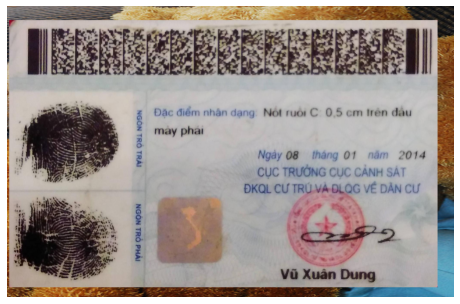

In [142]:


image = Image.open(image_path)
image = np.array(image)
background_image = cv2.cvtColor(cv2.imread(background_path), cv2.COLOR_BGR2RGB) 

expanded_img = expanded_image(image, background_image, x_expand_rate = 0.05, y_expand_rate = 0.1)
expanded_img = Image.fromarray(expanded_img)
plot_img(expanded_img)

In [139]:
%%timeit
expanded_img = expanded_image(image, background_image, x_expand_rate = 0.05, y_expand_rate = 0.1)


3.36 ms ± 97.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Load data

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json


In [23]:
class CustomDataset(Dataset):
    def __init__(self, json_file, transform=None):
        self.transform = transform

        # Load the JSON file
        with open(json_file, 'r') as f:
            data_json = json.load(f)
        
        self.classes = data_json['classes']
        self.samples = data_json['samples']
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        sample = self.samples[index]
        image_path = os.path.join("./data", sample['image_path']) 
        label = int(sample['label'])

        # Load the image
        image = Image.open(image_path).convert('RGB')
        
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
        
        return image, label

class SimpleModel(nn.Module):
    def __init__(self, class_num = 2, w = 1024, h = 1024):
        super(SimpleModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Load the JSON file
        self.classifier = nn.Sequential(
            nn.Linear(32 * int(w/4) * int(h/4), 64),
            nn.ReLU(),
            nn.Linear(64, class_num)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



In [24]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to a fixed size
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])


# with open("./data/labels.json", "r") as f:
#     data_json = json.load(f)
dataset = CustomDataset("./data/labels.json", transform=transform)


In [25]:
batch_size = 4
train_dataset = CustomDataset("./data/train.json", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset("./data/val.json", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [62]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1, progress = True)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(train_dataset.classes))
# model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1, progress = True)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_dataset.classes))

In [43]:
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
# num_features = model.fc.in_features
# model.fc = torch.nn.Linear(num_features, len(train_dataset.classes))
# model = SimpleModel(class_num = 2, w = 224, h = 224)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True, weights=MobileNet_V2_Weights.IMAGENET1K_V1)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_dataset.classes))

In [64]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [65]:



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
best_acc = 0
num_epochs = 5
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_dataset)
    # print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}')

    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_dataset)
    accuracy = correct / len(val_dataset)
    if accuracy > best_acc:
        best_acc = accuracy
        torch.save(model.state_dict(), './weight/best_accuracy.pth')
    # print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

    


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [62]:
torch.save(model.state_dict(), './weight/lastest_v3.pth')

Validation Loss: 0.0093, Accuracy: 0.9950


In [92]:
model.graph.output

[name: "400"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 2
      }
    }
  }
}
]

#### Test 

In [3]:
from tqdm import tqdm
import yaml
import os
from torchvision import transforms
from PIL import Image
import torch
from model.model import load_model
import random

In [ ]:

yaml_path = "./config/train_config.yml"
with open(yaml_path, 'r') as file:
    config_gen = yaml.safe_load(file)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = load_model(model_name = config_gen['model_name'],
                   num_classes =  len(config_gen['classes']),
                   w = config_gen['fixed_w'], 
                   h = config_gen['fixed_h'])

model.load_state_dict(torch.load(config_gen['inference_weight']))
model.eval()
model.to(device)

transform = transforms.Compose([
    transforms.Resize((config_gen['fixed_w'], config_gen['fixed_h'])),  # Resize the image to a fixed size
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

image_folder = config_gen['image_folder']
# for filename in os.listdir(image_folder):
#     # Load and preprocess the test image
#     test_image = Image.open(os.path.join(image_folder, filename)).convert('RGB')
#     test_image = transform(test_image)
#     test_image = test_image.unsqueeze(0)  # Add a batch dimension

#     # Make predictions on the test image
#     with torch.no_grad():
#         outputs = model(test_image.to(device))
#         _, predicted = torch.max(outputs, 1)
        
#     # Get the predicted label
#     predicted_label = config_gen["classes"][predicted.item()]

#     print(f"{filename}")
#     print(f'Predicted label: {predicted_label}')


test_num = 20
correct = 0
for i in range(test_num):
    filename = random.choice(os.listdir(image_folder))
    image_path = os.path.join(image_folder, filename)

    image = Image.open(image_path).convert("RGB")
    if "180" in filename:
        image = image.rotate(180, expand = True)
    
    label = random.randint(0, 3)
    image = image.rotate(int(90*label), expand=True)
    
    test_image = transform(image)
    test_image = test_image.unsqueeze(0)  # Add a batch dimension

    # Make predictions on the test image
    with torch.no_grad():
        outputs = model(test_image.to(device))
        _, predicted = torch.max(outputs, 1)
        
    # Get the predicted label
    predicted_label = config_gen["classes"][predicted.item()]

    # print(f"{filename}")
    plot_img(image)
    print(f"Groundtruth: {label*90}")
    print(f'Predicted label: {int(predicted.item())*90}')
    print("="*15)

# ID Card Rotation Check

This code is used to check if an ID card image is rotated 180 degrees or not.

## Available Models

The following models are available for rotation detection:

- SimpleModel with Conv2d
- mobilenet_v3_small
- mobilenet_v3_large

## Installation
Install the required dependencies. It is recommended to set up a virtual environment:
```shell
    pip install -r requirements.txt
```

## Usage
1. Prepare the training data:
    - Place ID card images in the ./images folder.
    - Create a JSON file (data.json) in the following format:

    ```json
    {
    "classes": ["0", "1"],
    "samples": [
        {
            "image_path": "./images/cccd_chip_back_0000.jpg",
            "label": "0"
        },
        {
            "image_path": "./images/cccd_chip_back_0001.jpg",
            "label": "0"
        },
        ...
    ]
    }
    ```

2. Configure the training settings: Modify the configuration file (./config/train_config.yml) to specify the model, hyperparameters, and training options.


3. Train the model: Run the training script:
```shell
    python train.py
```


4. Test the model: image folder and weight path in train_config.yml
```shell
    python inference.py
```
    
